# Imports

In [1]:
import numpy as np
import cvxpy as cp
import yfinance as yf
import matplotlib.pyplot as plt

# Generating Data

In [2]:
class Ticker:
    def __init__(self, tickers, years):
        self.tickers = tickers
        self.years = years
        self.data = self.download_data()

    def download_data(self):
        data = yf.download(self.tickers, period=f'{self.years}y')
        return data

    def get_returns(self):
        if 'Adj Close' in self.data.columns:
            data = self.data['Adj Close']
        else:
            data = self.data['Close']
        returns = data.pct_change().dropna()
        return returns

# MPT Class

In [3]:
class Optimizer:
    def __init__(self, tickers, years, risk_tolerance):
        self.tickers = tickers
        self.years = years
        self.risk_tolerance = risk_tolerance
        self.ticker_data = Ticker(tickers, years)
        self.returns = self.ticker_data.get_returns().mean() * 252
        self.cov_matrix = self.ticker_data.get_returns().cov() * 252

    def optimal_portfolio_selector(self):
        num_assets = len(self.tickers)
        returns = self.returns.values
        cov_matrix = self.cov_matrix.values

        # Define the optimization variables
        weights = cp.Variable(num_assets)
        portfolio_return = cp.sum(cp.multiply(returns, weights))
        portfolio_risk = cp.quad_form(weights, cov_matrix)

        # The sum of the first two weights is less than or equal to 0.6
        constraints = [cp.sum(weights) == 1, weights >= 0, cp.sum(weights[:2]) <= 0.6]

        # To encourage diversification in the portfolio
        regularization = cp.sum_squares(weights - (1 / num_assets))

        # # Objective function, maximize return while minimizing risk and encouraging diversification (After testing 0.5 was the closest to the optimal)
        objective = cp.Maximize(portfolio_return - self.risk_tolerance * portfolio_risk - 0.5 * regularization)


        prob = cp.Problem(objective, constraints)
        prob.solve()

        optimal_weights = weights.value
        optimal_return = portfolio_return.value
        optimal_risk = np.sqrt(portfolio_risk.value)

        return optimal_return, optimal_weights, optimal_risk
    

    def get_returns(self):
        return self.returns
    
    def get_cov_matrix(self):
        return self.cov_matrix

# Main Class

[*********************100%%**********************]  4 of 4 completed


Optimal portfolio return: 0.3659391714803646
Optimal portfolio weights: [0.27651903 0.07845471 0.1026204  0.54240586]
Optimal portfolio risk (Standard deviation): 0.24481707745842593
Sharpe ratio: 1.3722048109058598


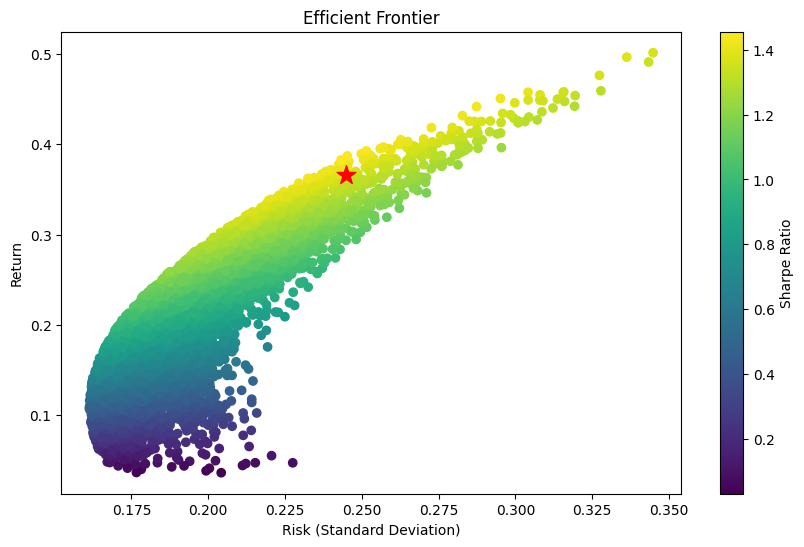

Top 3 Stocks with the highest weights:
Ticker: 8230.SR, Weight: 54.24%
Ticker: 2222.SR, Weight: 27.65%
Ticker: 1120.SR, Weight: 10.26%


In [4]:
tickers = ['2222.SR', '2010.SR', '1120.SR', '8230.SR']
years = 5
risk_tolerance = 0.5

# Test the optimal_portfolio_selector method with different regularization coefficients
# coefficients = [0.1, 0.3, 0.5]

# for coeff in coefficients:
#     optimizer = Optimizer(tickers, years, risk_tolerance)
#     optimal_return, optimal_weights, optimal_risk = optimizer.optimal_portfolio_selector(coeff)
#     print(f"Regularization Coefficient: {coeff}")
#     print(f"Optimal Portfolio Return: {optimal_return}")
#     print(f"Optimal Portfolio Weights: {optimal_weights}")
#     print(f"Optimal Portfolio Risk (Standard Deviation): {optimal_risk}")

# Instance of the optimizer class
mpt = Optimizer(tickers, years, risk_tolerance)

# Find the optimal portfolio
optimal_return, optimal_weights, optimal_risk = mpt.optimal_portfolio_selector()

print("Optimal portfolio return:", optimal_return)
print("Optimal portfolio weights:", optimal_weights)
print("Optimal portfolio risk (Standard deviation):", optimal_risk)

# Sharpe ratio
risk_free_rate = 0.03  # For a rate of 3%
sharpe_ratio = (optimal_return - risk_free_rate) / optimal_risk
print("Sharpe ratio:", sharpe_ratio)

# Efficient frontier
returns = mpt.get_returns().values
cov_matrix = mpt.get_cov_matrix().values
num_portfolios = 10000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    portfolio_return = np.dot(weights, returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_risk = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
    results[0, i] = portfolio_return
    results[1, i] = portfolio_risk
    results[2, i] = sharpe_ratio

# Efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_risk, optimal_return, color='red', marker='*', s=200)  # Highlight the optimal portfolio
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()

# Rank the top 3 stocks with the highest weights
top_indices = np.argsort(optimal_weights)[-3:][::-1]  # Top 3 weights in descending order
print("Top 3 Stocks with the highest weights:")
for i in top_indices:
    print(f"Ticker: {tickers[i]}, Weight: {optimal_weights[i]*100 :.2f}%")